In [59]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy
from datetime import datetime
import statsmodels.formula.api as smf

from matplotlib import style
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties
from pylab import mpl
import platform


system = platform.system()
if system == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei']  
    plt.rcParams['axes.unicode_minus'] = False  
elif system == 'Darwin':  
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  
    plt.rcParams['axes.unicode_minus'] = False
else: 
    plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']  
    plt.rcParams['axes.unicode_minus'] = False


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_columns', None)

print(f"当前操作系统: {system}")
print(f"字体设置: {plt.rcParams['font.sans-serif']}")

当前操作系统: Windows
字体设置: ['SimHei']


In [60]:
cross = pd.read_csv('d:\python2025/TRD_Mnth202509.csv')
from pandas.tseries.offsets import MonthEnd

cross['month'] = pd.to_datetime(cross['Trdmnt'], format='%Y-%m') + MonthEnd(1)

cross['Stkcd'] = cross['Stkcd'].apply(lambda x: '{:0>6}'.format(x))

cross.rename(columns={'Mretwd': 'Return', 'Msmvosd': 'floatingvalue', 'Msmvttl': 'totalvalue'}, inplace=True)


rf_data = pd.read_csv('d:\python2025/Marketret_mon_stock2024.csv')

rf_data['month'] = pd.to_datetime(rf_data['month'], format='%b %Y') + MonthEnd(1)

rf_data = rf_data[['month', 'rfmonth']]


cross = pd.merge(cross, rf_data, on='month', how='left')


cross = cross.sort_values(by=['Stkcd', 'month'])
cross['list_month'] = cross.groupby('Stkcd').cumcount() + 1


cross['ret'] = cross['Return'] - cross['rfmonth']
cross['floatingvalue'] = cross['floatingvalue'] * 1000
cross['totalvalue'] = cross['totalvalue'] * 1000

cross

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret
0,000001,1991-04,3,49.00,30,43.68,13400,6.150000e+05,1.157520e+09,2.118487e+09,20,NaN,NaN,4,1991-04-03,NaN,NaN,1991-04-30,0.006651,1,NaN
1,000001,1991-05,2,43.46,31,38.34,187800,7.675000e+06,1.016010e+09,1.859497e+09,24,-0.122253,0.235714,4,1991-04-03,NaN,NaN,1991-05-31,0.006092,2,-0.128345
2,000001,1991-06,1,38.53,28,33.99,30600,1.094000e+06,9.007350e+08,1.648521e+09,23,-0.113459,-0.113459,4,1991-04-03,NaN,NaN,1991-06-30,0.006092,3,-0.119551
3,000001,1991-07,1,33.65,31,29.54,6100,1.940430e+05,7.828100e+08,1.432695e+09,16,-0.130921,-0.130921,4,1991-04-03,NaN,NaN,1991-07-31,0.006092,4,-0.137013
4,000001,1991-08,1,29.39,31,15.00,3243100,4.957624e+07,6.748338e+08,1.346275e+09,15,-0.411588,-0.411587,4,1991-08-01,NaN,NaN,1991-08-31,0.006092,5,-0.417680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886908,920992,2025-05,6,20.00,30,20.46,92609592,1.922463e+09,5.707967e+08,1.979115e+09,19,0.051312,0.051715,64,2023-04-25,0.0,0.0,2025-05-31,NaN,32,NaN
886909,920992,2025-06,3,20.40,30,21.26,73152031,1.580767e+09,5.931152e+08,2.056500e+09,20,0.039101,0.039101,64,2023-04-25,0.0,0.0,2025-06-30,NaN,33,NaN
886910,920992,2025-07,1,21.13,31,22.44,96064221,2.126994e+09,6.260351e+08,2.170642e+09,23,0.055503,0.055503,64,2023-04-25,0.0,0.0,2025-07-31,NaN,34,NaN
886911,920992,2025-08,1,22.12,29,21.65,63953451,1.432608e+09,6.039955e+08,2.094225e+09,21,-0.035205,-0.035205,64,2023-04-25,0.0,0.0,2025-08-31,NaN,35,NaN


In [61]:

all_months = pd.DataFrame(cross['month'].unique(), columns=['month'])
all_stocks = pd.DataFrame(cross['Stkcd'].unique(), columns=['Stkcd'])

full_index = all_stocks.merge(all_months, how='cross')

cross_full = full_index.merge(cross, on=['Stkcd', 'month'], how='left')

cross_full = cross_full.sort_values(['Stkcd', 'month'])

cross_full['next_ret'] = cross_full.groupby('Stkcd')['ret'].shift(-1)


cross = cross.merge(cross_full[['Stkcd', 'month', 'next_ret']], 
                    on=['Stkcd', 'month'], how='right')


cross['Cumsum_tradingday'] = cross.groupby('Stkcd')['Ndaytrd'].transform(lambda x: x.rolling(window=12, min_periods=1).sum())
print("方法1完成：补全日期序列后使用shift")

cross = cross[(cross['month'] >= '1995-01-31') & (cross['month'] <= '2024-12-31')]
cross

方法1完成：补全日期序列后使用shift


,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday
49,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0
50,000001,1995-02,13.0,10.60,28.0,10.63,8544200.0,9.192790e+07,3.161060e+09,4.582260e+09,12.0,0.008539,0.008539,4.0,1994-09-02,NaN,NaN,1995-02-28,0.008719,47.0,-0.000180,0.003511,244.0
51,000001,1995-03,1.0,10.63,31.0,10.76,18810600.0,2.059094e+08,3.199719e+09,4.638299e+09,23.0,0.012230,0.012230,4.0,1994-09-02,NaN,NaN,1995-03-31,0.008719,48.0,0.003511,-0.108161,244.0
52,000001,1995-04,3.0,10.78,28.0,9.69,13235500.0,1.380604e+08,2.881531e+09,4.177055e+09,20.0,-0.099442,-0.099442,4.0,1994-09-02,NaN,NaN,1995-04-30,0.008719,49.0,-0.108161,0.002633,243.0
53,000001,1995-05,2.0,9.69,31.0,9.80,53197900.0,6.049730e+08,2.914242e+09,4.224473e+09,22.0,0.011352,0.011352,4.0,1994-09-02,NaN,NaN,1995-05-31,0.008719,50.0,0.002633,-0.073005,244.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2453228,920992,2024-08,1.0,8.50,30.0,8.19,14436632.0,1.185912e+08,2.284861e+08,7.922264e+08,22.0,-0.037603,-0.037603,64.0,2023-04-25,0.0,0.0,2024-08-31,0.001118,23.0,-0.038721,0.276049,242.0
2453229,920992,2024-09,2.0,8.15,30.0,10.46,18109819.0,1.566140e+08,2.918149e+08,1.011806e+09,19.0,0.277167,0.277167,64.0,2023-04-25,0.0,0.0,2024-09-30,0.001118,24.0,0.276049,0.389895,241.0
2453230,920992,2024-10,8.0,13.02,31.0,14.55,86774237.0,1.145494e+09,4.059185e+08,1.407435e+09,18.0,0.391013,0.391013,64.0,2023-04-25,0.0,0.0,2024-10-31,0.001118,25.0,0.389895,0.241494,242.0
2453231,920992,2024-11,1.0,14.69,29.0,18.08,130783392.0,2.346534e+09,5.043990e+08,1.748895e+09,21.0,0.242612,0.242612,64.0,2023-04-25,0.0,0.0,2024-11-30,0.001118,26.0,0.241494,-0.243928,241.0


In [62]:
from pandas.tseries.offsets import MonthEnd 
Market_ret = pd.read_csv('d:\python2025/Marketret_mon_stock2024.csv')
Market_ret['month'] = pd.to_datetime(Market_ret['month'], format='%b %Y') + MonthEnd(0)
Market_ret.set_index('month', inplace=True)
Market_ret.sort_index(inplace=True)
Market_ret = Market_ret.drop(columns=['Unnamed: 0'])
Market_ret.rename(columns={'ret': 'MKT'}, inplace=True)
Market_ret

,MarketR,MarketR_e,rfmonth,MKT,ret_e,marketret3,marketret6,marketret12,Q
month,,,,,,,,,
1991-01-31,0.029998,0.036554,0.006930,0.023068,0.029624,-0.084127,-0.305662,0.254049,1991 Q1
1991-02-28,0.010203,0.021860,0.006930,0.003273,0.014930,-0.183573,-0.384745,0.241492,1991 Q1
1991-03-31,-0.099663,-0.060425,0.006930,-0.106593,-0.067355,-0.252928,-0.445049,0.288857,1991 Q1
1991-04-30,-0.079652,-0.031449,0.006651,-0.086303,-0.038100,-0.234776,-0.394937,0.691749,1991 Q2
1991-05-31,-0.074521,0.005375,0.006092,-0.080613,-0.000717,-0.236294,0.181673,1.542701,1991 Q2
...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,0.001118,-0.032586,-0.034803,0.151050,NaN,NaN,2024 Q3
2024-09-30,0.195992,0.227078,0.001118,0.194874,0.225960,0.200147,NaN,NaN,2024 Q3
2024-10-31,-0.003409,0.070220,0.001118,-0.004527,0.069102,0.000228,NaN,NaN,2024 Q4


In [63]:
cross = pd.merge(cross,Market_ret[['MKT']],left_on='month',right_on='month',how='left')
cross

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday,MKT
0,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0,-0.125017
1,000001,1995-02,13.0,10.60,28.0,10.63,8544200.0,9.192790e+07,3.161060e+09,4.582260e+09,12.0,0.008539,0.008539,4.0,1994-09-02,NaN,NaN,1995-02-28,0.008719,47.0,-0.000180,0.003511,244.0,-0.022778
2,000001,1995-03,1.0,10.63,31.0,10.76,18810600.0,2.059094e+08,3.199719e+09,4.638299e+09,23.0,0.012230,0.012230,4.0,1994-09-02,NaN,NaN,1995-03-31,0.008719,48.0,0.003511,-0.108161,244.0,0.122163
3,000001,1995-04,3.0,10.78,28.0,9.69,13235500.0,1.380604e+08,2.881531e+09,4.177055e+09,20.0,-0.099442,-0.099442,4.0,1994-09-02,NaN,NaN,1995-04-30,0.008719,49.0,-0.108161,0.002633,243.0,-0.113023
4,000001,1995-05,2.0,9.69,31.0,9.80,53197900.0,6.049730e+08,2.914242e+09,4.224473e+09,22.0,0.011352,0.011352,4.0,1994-09-02,NaN,NaN,1995-05-31,0.008719,50.0,0.002633,-0.073005,244.0,0.166736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2112835,920992,2024-08,1.0,8.50,30.0,8.19,14436632.0,1.185912e+08,2.284861e+08,7.922264e+08,22.0,-0.037603,-0.037603,64.0,2023-04-25,0.0,0.0,2024-08-31,0.001118,23.0,-0.038721,0.276049,242.0,-0.032586
2112836,920992,2024-09,2.0,8.15,30.0,10.46,18109819.0,1.566140e+08,2.918149e+08,1.011806e+09,19.0,0.277167,0.277167,64.0,2023-04-25,0.0,0.0,2024-09-30,0.001118,24.0,0.276049,0.389895,241.0,0.194874
2112837,920992,2024-10,8.0,13.02,31.0,14.55,86774237.0,1.145494e+09,4.059185e+08,1.407435e+09,18.0,0.391013,0.391013,64.0,2023-04-25,0.0,0.0,2024-10-31,0.001118,25.0,0.389895,0.241494,242.0,-0.004527
2112838,920992,2024-11,1.0,14.69,29.0,18.08,130783392.0,2.346534e+09,5.043990e+08,1.748895e+09,21.0,0.242612,0.242612,64.0,2023-04-25,0.0,0.0,2024-11-30,0.001118,26.0,0.241494,-0.243928,241.0,0.008606


In [64]:
cross = cross[cross['Ndaytrd'] >= 7]
cross = cross[cross['Clsdt'] >= 5]
cross = cross[cross['list_month'] > 6]
cross = cross[cross['Cumsum_tradingday'] >= 100]
cross = cross[(cross['Markettype'] == 1) | (cross['Markettype'] == 4) | (cross['Markettype'] == 6)]
cross

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday,MKT
0,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0,-0.125017
1,000001,1995-02,13.0,10.60,28.0,10.63,8544200.0,9.192790e+07,3.161060e+09,4.582260e+09,12.0,0.008539,0.008539,4.0,1994-09-02,NaN,NaN,1995-02-28,0.008719,47.0,-0.000180,0.003511,244.0,-0.022778
2,000001,1995-03,1.0,10.63,31.0,10.76,18810600.0,2.059094e+08,3.199719e+09,4.638299e+09,23.0,0.012230,0.012230,4.0,1994-09-02,NaN,NaN,1995-03-31,0.008719,48.0,0.003511,-0.108161,244.0,0.122163
3,000001,1995-04,3.0,10.78,28.0,9.69,13235500.0,1.380604e+08,2.881531e+09,4.177055e+09,20.0,-0.099442,-0.099442,4.0,1994-09-02,NaN,NaN,1995-04-30,0.008719,49.0,-0.108161,0.002633,243.0,-0.113023
4,000001,1995-05,2.0,9.69,31.0,9.80,53197900.0,6.049730e+08,2.914242e+09,4.224473e+09,22.0,0.011352,0.011352,4.0,1994-09-02,NaN,NaN,1995-05-31,0.008719,50.0,0.002633,-0.073005,244.0,0.166736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779475,605599,2024-08,1.0,11.51,30.0,10.74,60492042.0,6.675452e+08,6.300920e+09,8.353334e+09,22.0,-0.065274,-0.065274,1.0,2022-09-09,0.0,0.0,2024-08-31,0.001118,36.0,-0.066392,0.105958,242.0,-0.032586
1779476,605599,2024-09,2.0,10.56,30.0,11.89,68255221.0,7.093424e+08,9.247778e+09,9.247778e+09,19.0,0.107076,0.107076,1.0,2024-09-09,0.0,0.0,2024-09-30,0.001118,37.0,0.105958,-0.105407,241.0,0.194874
1779477,605599,2024-10,8.0,12.91,31.0,10.65,100720810.0,1.106652e+09,8.283334e+09,8.283334e+09,18.0,-0.104289,-0.104289,1.0,2024-09-09,0.0,0.0,2024-10-31,0.001118,38.0,-0.105407,0.078694,242.0,-0.004527
1779478,605599,2024-11,1.0,10.63,29.0,11.50,108258572.0,1.199394e+09,8.944445e+09,8.944445e+09,21.0,0.079812,0.079812,1.0,2024-09-09,0.0,0.0,2024-11-30,0.001118,39.0,0.078694,-0.014161,241.0,0.008606


In [65]:
EP = pd.read_csv('d:\python2025/EP_individual_mon2024.csv')
EP['Stkcd'] = EP['Stkcd'].apply(lambda x: '{:0>6}'.format(x))
# EP['month'] = pd.to_datetime(EP['month'], format='%Y-%m') + MonthEnd(1)
# EP = EP[['Stkcd', 'month', 'EP_individual']]
EP

,Stkcd,month,matchearnings,recent_earnings,floatingvalue,totalvalue,ratio,Clsprc,ep,ep_recent
0,000001,1991.250000,NaN,NaN,1.157520e+09,2.118487e+09,0.54639,43.68,NaN,NaN
1,000001,1991.333333,NaN,NaN,1.016010e+09,1.859497e+09,0.54639,38.34,NaN,NaN
2,000001,1991.416667,NaN,NaN,9.007350e+08,1.648521e+09,0.54639,33.99,NaN,NaN
3,000001,1991.500000,NaN,NaN,7.828100e+08,1.432695e+09,0.54639,29.54,NaN,NaN
4,000001,1991.583333,NaN,NaN,6.748338e+08,1.346275e+09,0.50126,15.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
809599,605599,2024.583333,6.614476e+08,3.884148e+08,6.300920e+09,8.353334e+09,0.75430,10.74,0.079184,0.046498
809600,605599,2024.666667,6.614476e+08,3.884148e+08,9.247778e+09,9.247778e+09,1.00000,11.89,0.071525,0.042001
809601,605599,2024.750000,6.455339e+08,5.286127e+08,8.283334e+09,8.283334e+09,1.00000,10.65,0.077932,0.063816
809602,605599,2024.833333,6.455339e+08,5.286127e+08,8.944445e+09,8.944445e+09,1.00000,11.50,0.072171,0.059100


In [66]:
EP = pd.read_csv('d:\python2025/EP_individual_mon2024.csv')
EP['Stkcd'] = EP['Stkcd'].apply(lambda x: '{:0>6}'.format(x))

EP['year'] = EP['month'].astype(int)
EP['month_decimal'] = EP['month'] - EP['year']
EP['month_num'] = (EP['month_decimal'] * 12).round().astype(int) + 1

EP.loc[EP['month_num'] > 12, 'year'] += 1
EP.loc[EP['month_num'] > 12, 'month_num'] -= 12
EP['month'] = pd.to_datetime(EP['year'].astype(str) + '-' + EP['month_num'].astype(str) + '-01')
EP = EP.drop(['year', 'month_decimal', 'month_num'], axis=1)
EP['month'] = EP['month'] + MonthEnd(1)
EP = EP[['Stkcd', 'month', 'ep', 'ep_recent']]
EP

,Stkcd,month,ep,ep_recent
0,000001,1991-04-30,NaN,NaN
1,000001,1991-05-31,NaN,NaN
2,000001,1991-06-30,NaN,NaN
3,000001,1991-07-31,NaN,NaN
4,000001,1991-08-31,NaN,NaN
...,...,...,...,...
809599,605599,2024-08-31,0.079184,0.046498
809600,605599,2024-09-30,0.071525,0.042001
809601,605599,2024-10-31,0.077932,0.063816
809602,605599,2024-11-30,0.072171,0.059100


In [67]:
cross = pd.merge(cross,EP[['Stkcd','month','ep','ep_recent']],on=['Stkcd','month'],how='left')
cross

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday,MKT,ep,ep_recent
0,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0,-0.125017,0.078427,0.078427
1,000001,1995-02,13.0,10.60,28.0,10.63,8544200.0,9.192790e+07,3.161060e+09,4.582260e+09,12.0,0.008539,0.008539,4.0,1994-09-02,NaN,NaN,1995-02-28,0.008719,47.0,-0.000180,0.003511,244.0,-0.022778,0.077763,0.077763
2,000001,1995-03,1.0,10.63,31.0,10.76,18810600.0,2.059094e+08,3.199719e+09,4.638299e+09,23.0,0.012230,0.012230,4.0,1994-09-02,NaN,NaN,1995-03-31,0.008719,48.0,0.003511,-0.108161,244.0,0.122163,0.076823,0.076823
3,000001,1995-04,3.0,10.78,28.0,9.69,13235500.0,1.380604e+08,2.881531e+09,4.177055e+09,20.0,-0.099442,-0.099442,4.0,1994-09-02,NaN,NaN,1995-04-30,0.008719,49.0,-0.108161,0.002633,243.0,-0.113023,0.085306,0.085306
4,000001,1995-05,2.0,9.69,31.0,9.80,53197900.0,6.049730e+08,2.914242e+09,4.224473e+09,22.0,0.011352,0.011352,4.0,1994-09-02,NaN,NaN,1995-05-31,0.008719,50.0,0.002633,-0.073005,244.0,0.166736,0.084349,0.084349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619097,605599,2024-08,1.0,11.51,30.0,10.74,60492042.0,6.675452e+08,6.300920e+09,8.353334e+09,22.0,-0.065274,-0.065274,1.0,2022-09-09,0.0,0.0,2024-08-31,0.001118,36.0,-0.066392,0.105958,242.0,-0.032586,0.079184,0.046498
619098,605599,2024-09,2.0,10.56,30.0,11.89,68255221.0,7.093424e+08,9.247778e+09,9.247778e+09,19.0,0.107076,0.107076,1.0,2024-09-09,0.0,0.0,2024-09-30,0.001118,37.0,0.105958,-0.105407,241.0,0.194874,0.071525,0.042001
619099,605599,2024-10,8.0,12.91,31.0,10.65,100720810.0,1.106652e+09,8.283334e+09,8.283334e+09,18.0,-0.104289,-0.104289,1.0,2024-09-09,0.0,0.0,2024-10-31,0.001118,38.0,-0.105407,0.078694,242.0,-0.004527,0.077932,0.063816
619100,605599,2024-11,1.0,10.63,29.0,11.50,108258572.0,1.199394e+09,8.944445e+09,8.944445e+09,21.0,0.079812,0.079812,1.0,2024-09-09,0.0,0.0,2024-11-30,0.001118,39.0,0.078694,-0.014161,241.0,0.008606,0.072171,0.059100


In [68]:
fenweishu = pd.DataFrame(
    cross.groupby(['month'])['ep'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
fenweishu = fenweishu.reset_index()
fenweishu = fenweishu.pivot_table(index='month',columns='level_1',values='ep')
fenweishu.columns = ['one','two','three','four','five','six','seven','eight','nine']
fenweishu

,one,two,three,four,five,six,seven,eight,nine
month,,,,,,,,,
1995-01-31,0.003740,0.021281,0.033164,0.039819,0.044917,0.052511,0.073509,0.088339,0.108585
1995-02-28,0.017802,0.027244,0.035524,0.039235,0.046534,0.057727,0.068244,0.085852,0.107936
1995-03-31,0.019806,0.025710,0.031130,0.036242,0.039984,0.047927,0.059745,0.079132,0.097067
1995-04-30,0.022996,0.030191,0.037497,0.048093,0.057527,0.068974,0.082006,0.094234,0.118343
1995-05-31,0.019335,0.023981,0.031124,0.039584,0.047728,0.057994,0.069575,0.084349,0.107694
...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.071234,-0.014382,0.004156,0.016561,0.028364,0.040366,0.053579,0.068858,0.091599
2024-09-30,-0.057617,-0.011582,0.003542,0.013776,0.023859,0.034048,0.044790,0.058037,0.077940
2024-10-31,-0.051899,-0.012569,0.002158,0.011550,0.021554,0.032422,0.043560,0.056971,0.077968


In [69]:
portfolio = pd.merge(cross,fenweishu,on='month')
portfolio['sort'] = np.where(
    portfolio['ep'] <= portfolio['one'], 'P1',
    np.where(
        portfolio['ep'] <= portfolio['two'], 'P2',
        np.where(
            portfolio['ep'] <= portfolio['three'], 'P3',
            np.where(
                portfolio['ep'] <= portfolio['four'], 'P4',
                np.where(
                    portfolio['ep'] <= portfolio['five'], 'P5',
                    np.where(
                        portfolio['ep'] <= portfolio['six'], 'P6',
                        np.where(
                            portfolio['ep'] <= portfolio['seven'], 'P7',
                            np.where(
                                portfolio['ep'] <= portfolio['eight'], 'P8',
                                np.where(
                                    portfolio['ep'] <= portfolio['nine'],
                                    'P9', 'Pmax')))))))))
portfolio = portfolio.dropna(subset=['floatingvalue','next_ret','ep'])
portfolio

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday,MKT,ep,ep_recent,one,two,three,four,five,six,seven,eight,nine,sort
0,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0,-0.125017,0.078427,0.078427,0.003740,0.021281,0.033164,0.039819,0.044917,0.052511,0.073509,0.088339,0.108585,P8
2,000003,1995-01,3.0,5.95,27.0,5.53,2902600.0,1.670475e+07,5.891124e+08,8.474018e+08,19.0,-0.085950,-0.085950,4.0,1994-06-08,NaN,NaN,1995-01-31,0.008719,43.0,-0.094669,-0.008719,247.0,-0.125017,0.027172,0.036314,0.003740,0.021281,0.033164,0.039819,0.044917,0.052511,0.073509,0.088339,0.108585,P3
3,000004,1995-01,3.0,6.02,27.0,5.57,1799300.0,1.055607e+07,2.109376e+08,4.252277e+08,19.0,-0.088380,-0.088380,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,49.0,-0.097099,-0.003333,247.0,-0.125017,0.020553,0.020553,0.003740,0.021281,0.033164,0.039819,0.044917,0.052511,0.073509,0.088339,0.108585,P2
7,000008,1995-01,3.0,5.85,27.0,5.46,1507200.0,8.656138e+06,1.347458e+08,2.812213e+08,19.0,-0.080808,-0.080808,4.0,1994-09-19,NaN,NaN,1995-01-31,0.008719,33.0,-0.089527,-0.025203,245.0,-0.125017,0.037944,0.037944,0.003740,0.021281,0.033164,0.039819,0.044917,0.052511,0.073509,0.088339,0.108585,P4
8,000009,1995-01,3.0,5.00,27.0,4.57,11547700.0,5.510373e+07,1.625397e+09,2.938582e+09,19.0,-0.082329,-0.082329,4.0,1994-12-31,NaN,NaN,1995-01-31,0.008719,44.0,-0.091048,-0.019660,246.0,-0.125017,0.143588,0.143588,0.003740,0.021281,0.033164,0.039819,0.044917,0.052511,0.073509,0.088339,0.108585,Pmax
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619096,601958,2010-08,2.0,14.21,31.0,15.34,365862106.0,5.313984e+09,1.187322e+10,4.949611e+10,22.0,0.077247,0.077247,1.0,2010-05-17,NaN,NaN,2010-08-31,0.001856,29.0,0.075391,0.204141,243.0,0.023911,0.016252,0.009069,-0.006763,0.003495,0.009561,0.013952,0.018341,0.023106,0.030093,0.041128,0.058374,P5
619097,601988,2010-08,2.0,3.58,31.0,3.33,784185920.0,2.713500e+09,5.921370e+11,5.921370e+11,21.0,-0.069832,-0.069832,1.0,2009-07-06,NaN,NaN,2010-08-31,0.001856,50.0,-0.071688,0.001147,241.0,0.023911,0.111911,0.090954,-0.006763,0.003495,0.009561,0.013952,0.018341,0.023106,0.030093,0.041128,0.058374,Pmax
619099,601991,2010-08,2.0,7.17,31.0,6.90,101913694.0,7.214514e+08,5.840408e+10,6.206108e+10,21.0,-0.037657,-0.037657,1.0,2010-03-23,NaN,NaN,2010-08-31,0.001856,45.0,-0.039513,-0.010552,241.0,0.023911,0.030790,0.021472,-0.006763,0.003495,0.009561,0.013952,0.018341,0.023106,0.030093,0.041128,0.058374,P8
619100,601998,2010-08,2.0,5.97,31.0,5.63,589597327.0,3.441132e+09,1.487317e+11,1.607696e+11,22.0,-0.060100,-0.060100,1.0,2010-06-30,NaN,NaN,2010-08-31,0.001856,41.0,-0.061956,-0.097771,241.0,0.023911,0.081431,0.066990,-0.006763,0.003495,0.009561,0.013952,0.018341,0.023106,0.030093,0.041128,0.058374,Pmax


In [70]:
portfolio_value =  pd.DataFrame(
    portfolio.groupby(['month','sort']).apply(lambda x: np.average(x['next_ret'],weights = x['floatingvalue'])))
portfolio_value = portfolio_value.reset_index()
portfolio_value.columns = ['month', 'sort', 'p']
portfolio_value['month'] = portfolio_value['month'] + MonthEnd(1)
portfolio_value

,month,sort,p
0,1995-02-28,P1,-0.046564
1,1995-02-28,P2,-0.039864
2,1995-02-28,P3,0.004335
3,1995-02-28,P4,0.010141
4,1995-02-28,P5,-0.046855
...,...,...,...
3585,2024-12-31,P6,-0.026096
3586,2024-12-31,P7,-0.007706
3587,2024-12-31,P8,0.008303
3588,2024-12-31,P9,-0.001724


In [71]:
portfolio_value = portfolio_value.pivot_table(index='month',
                                                    columns='sort',
                                                    values='p')
portfolio_value['My_portfolio'] = portfolio_value['Pmax'] - portfolio_value['P1']
portfolio_value

sort,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio
month,,,,,,,,,,,
1995-02-28,-0.046564,-0.039864,0.004335,0.010141,-0.046855,-0.014133,0.004822,0.004398,0.005364,-0.004510,0.042054
1995-03-31,0.166651,0.039614,0.186807,0.105647,0.145939,0.211369,0.125131,0.011332,0.115488,0.033143,-0.133508
1995-04-30,-0.120087,-0.098151,-0.098700,-0.116309,-0.102409,-0.120334,-0.137053,-0.103988,-0.097787,-0.116950,0.003137
1995-05-31,0.169245,0.211190,0.224196,0.246332,0.226090,0.166345,0.208711,0.125688,0.106342,0.059119,-0.110126
1995-06-30,-0.101912,-0.111554,-0.118523,-0.122750,-0.120498,-0.086887,-0.073876,-0.080503,-0.079607,-0.063207,0.038705
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.044099,-0.052295,-0.052839,-0.053067,-0.043945,-0.034611,-0.027298,-0.035942,-0.021996,-0.017424,0.026674
2024-09-30,0.279909,0.242627,0.202610,0.204982,0.195948,0.198237,0.192730,0.195068,0.180448,0.133349,-0.146560
2024-10-31,0.125731,0.130360,0.076116,0.061446,0.036925,-0.001085,-0.061412,-0.037743,-0.041724,-0.044961,-0.170692


In [72]:
portfolio_value = portfolio_value['1995-01':'2023-12'].copy()
portfolio_value['month'] = pd.date_range(start='1995-01', periods=len(portfolio_value), freq='M')
portfolio_value.set_index('month', inplace = True)
portfolio_value

sort,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio
month,,,,,,,,,,,
1995-01-31,-0.046564,-0.039864,0.004335,0.010141,-0.046855,-0.014133,0.004822,0.004398,0.005364,-0.004510,0.042054
1995-02-28,0.166651,0.039614,0.186807,0.105647,0.145939,0.211369,0.125131,0.011332,0.115488,0.033143,-0.133508
1995-03-31,-0.120087,-0.098151,-0.098700,-0.116309,-0.102409,-0.120334,-0.137053,-0.103988,-0.097787,-0.116950,0.003137
1995-04-30,0.169245,0.211190,0.224196,0.246332,0.226090,0.166345,0.208711,0.125688,0.106342,0.059119,-0.110126
1995-05-31,-0.101912,-0.111554,-0.118523,-0.122750,-0.120498,-0.086887,-0.073876,-0.080503,-0.079607,-0.063207,0.038705
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,-0.075258,-0.073329,-0.069993,-0.058996,-0.063740,-0.054399,-0.045402,-0.059390,-0.059459,-0.055729,0.019529
2023-08-31,0.000297,-0.011474,-0.020423,-0.005836,-0.020143,-0.017650,-0.015962,-0.025660,-0.003915,0.019567,0.019270
2023-09-30,0.027781,-0.001684,-0.018551,-0.000788,-0.014727,-0.038236,-0.025111,-0.040837,-0.037748,-0.043455,-0.071235


In [73]:
model_port = smf.ols('My_portfolio ~ 1',
                 data=portfolio_value['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_port.summary())

                            OLS Regression Results                            
Dep. Variable:           My_portfolio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 02 Dec 2025   Prob (F-statistic):                nan
Time:                        09:09:54   Log-Likelihood:                 392.65
No. Observations:                 287   AIC:                            -783.3
Df Residuals:                     286   BIC:                            -779.6
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0044      0.003      1.501      0.1

In [74]:
fenweishu = pd.DataFrame(
    cross.groupby(['month'])['totalvalue'].quantile(0.3))
fenweishu.columns = ['fenweishu_guimo']
fenweishu

,fenweishu_guimo
month,
1995-01-31,4.713757e+08
1995-02-28,4.685400e+08
1995-03-31,5.569249e+08
1995-04-30,4.913312e+08
1995-05-31,5.796345e+08
...,...
2024-08-31,2.953591e+09
2024-09-30,3.589222e+09
2024-10-31,3.858400e+09


In [75]:
cross_new = pd.merge(cross,fenweishu,on='month',how='left')
cross_new = cross_new[cross_new['totalvalue'] > cross_new['fenweishu_guimo']]
cross_new

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday,MKT,ep,ep_recent,fenweishu_guimo
0,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0,-0.125017,0.078427,0.078427,4.713757e+08
1,000001,1995-02,13.0,10.60,28.0,10.63,8544200.0,9.192790e+07,3.161060e+09,4.582260e+09,12.0,0.008539,0.008539,4.0,1994-09-02,NaN,NaN,1995-02-28,0.008719,47.0,-0.000180,0.003511,244.0,-0.022778,0.077763,0.077763,4.685400e+08
2,000001,1995-03,1.0,10.63,31.0,10.76,18810600.0,2.059094e+08,3.199719e+09,4.638299e+09,23.0,0.012230,0.012230,4.0,1994-09-02,NaN,NaN,1995-03-31,0.008719,48.0,0.003511,-0.108161,244.0,0.122163,0.076823,0.076823,5.569249e+08
3,000001,1995-04,3.0,10.78,28.0,9.69,13235500.0,1.380604e+08,2.881531e+09,4.177055e+09,20.0,-0.099442,-0.099442,4.0,1994-09-02,NaN,NaN,1995-04-30,0.008719,49.0,-0.108161,0.002633,243.0,-0.113023,0.085306,0.085306,4.913312e+08
4,000001,1995-05,2.0,9.69,31.0,9.80,53197900.0,6.049730e+08,2.914242e+09,4.224473e+09,22.0,0.011352,0.011352,4.0,1994-09-02,NaN,NaN,1995-05-31,0.008719,50.0,0.002633,-0.073005,244.0,0.166736,0.084349,0.084349,5.796345e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619097,605599,2024-08,1.0,11.51,30.0,10.74,60492042.0,6.675452e+08,6.300920e+09,8.353334e+09,22.0,-0.065274,-0.065274,1.0,2022-09-09,0.0,0.0,2024-08-31,0.001118,36.0,-0.066392,0.105958,242.0,-0.032586,0.079184,0.046498,2.953591e+09
619098,605599,2024-09,2.0,10.56,30.0,11.89,68255221.0,7.093424e+08,9.247778e+09,9.247778e+09,19.0,0.107076,0.107076,1.0,2024-09-09,0.0,0.0,2024-09-30,0.001118,37.0,0.105958,-0.105407,241.0,0.194874,0.071525,0.042001,3.589222e+09
619099,605599,2024-10,8.0,12.91,31.0,10.65,100720810.0,1.106652e+09,8.283334e+09,8.283334e+09,18.0,-0.104289,-0.104289,1.0,2024-09-09,0.0,0.0,2024-10-31,0.001118,38.0,-0.105407,0.078694,242.0,-0.004527,0.077932,0.063816,3.858400e+09
619100,605599,2024-11,1.0,10.63,29.0,11.50,108258572.0,1.199394e+09,8.944445e+09,8.944445e+09,21.0,0.079812,0.079812,1.0,2024-09-09,0.0,0.0,2024-11-30,0.001118,39.0,0.078694,-0.014161,241.0,0.008606,0.072171,0.059100,4.083099e+09


In [76]:
fenweishu = pd.DataFrame(
    cross_new.groupby(['month'])['ep'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
fenweishu = fenweishu.reset_index()
fenweishu = fenweishu.pivot_table(index='month',columns='level_1',values='ep')
fenweishu.columns = ['one','two','three','four','five','six','seven','eight','nine']
fenweishu

,one,two,three,four,five,six,seven,eight,nine
month,,,,,,,,,
1995-01-31,0.011694,0.026337,0.038725,0.042651,0.051198,0.062911,0.081254,0.099120,0.112330
1995-02-28,0.020711,0.027461,0.034961,0.042902,0.047414,0.057495,0.078630,0.097774,0.110024
1995-03-31,0.019606,0.024940,0.027630,0.033458,0.039421,0.047050,0.061474,0.081681,0.104285
1995-04-30,0.023986,0.029562,0.037292,0.047827,0.057979,0.072796,0.088687,0.101487,0.129023
1995-05-31,0.019987,0.023862,0.030861,0.038425,0.047612,0.058119,0.075383,0.096088,0.117188
...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.037356,-0.000272,0.013614,0.025949,0.036918,0.048439,0.061138,0.077300,0.103333
2024-09-30,-0.033018,-0.001263,0.010554,0.020630,0.030301,0.040359,0.051131,0.064994,0.087420
2024-10-31,-0.036195,-0.004644,0.007842,0.017293,0.027926,0.038731,0.049751,0.063442,0.088219


In [77]:
portfolio = pd.merge(cross_new,fenweishu,on='month')
portfolio['sort'] = np.where(
    portfolio['ep'] <= portfolio['one'], 'P1',
    np.where(
        portfolio['ep'] <= portfolio['two'], 'P2',
        np.where(
            portfolio['ep'] <= portfolio['three'], 'P3',
            np.where(
                portfolio['ep'] <= portfolio['four'], 'P4',
                np.where(
                    portfolio['ep'] <= portfolio['five'], 'P5',
                    np.where(
                        portfolio['ep'] <= portfolio['six'], 'P6',
                        np.where(
                            portfolio['ep'] <= portfolio['seven'], 'P7',
                            np.where(
                                portfolio['ep'] <= portfolio['eight'], 'P8',
                                np.where(
                                    portfolio['ep'] <= portfolio['nine'],
                                    'P9', 'Pmax')))))))))
portfolio = portfolio.dropna(subset=['floatingvalue','next_ret','ep'])
portfolio

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday,MKT,ep,ep_recent,fenweishu_guimo,one,two,three,four,five,six,seven,eight,nine,sort
0,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0,-0.125017,0.078427,0.078427,4.713757e+08,0.011694,0.026337,0.038725,0.042651,0.051198,0.062911,0.081254,0.099120,0.11233,P7
2,000003,1995-01,3.0,5.95,27.0,5.53,2902600.0,1.670475e+07,5.891124e+08,8.474018e+08,19.0,-0.085950,-0.085950,4.0,1994-06-08,NaN,NaN,1995-01-31,0.008719,43.0,-0.094669,-0.008719,247.0,-0.125017,0.027172,0.036314,4.713757e+08,0.011694,0.026337,0.038725,0.042651,0.051198,0.062911,0.081254,0.099120,0.11233,P3
5,000009,1995-01,3.0,5.00,27.0,4.57,11547700.0,5.510373e+07,1.625397e+09,2.938582e+09,19.0,-0.082329,-0.082329,4.0,1994-12-31,NaN,NaN,1995-01-31,0.008719,44.0,-0.091048,-0.019660,246.0,-0.125017,0.143588,0.143588,4.713757e+08,0.011694,0.026337,0.038725,0.042651,0.051198,0.062911,0.081254,0.099120,0.11233,Pmax
8,000013,1995-01,3.0,4.44,27.0,4.05,2001700.0,8.477240e+06,1.728176e+08,9.132580e+08,19.0,-0.087838,-0.087838,4.0,1994-07-25,NaN,NaN,1995-01-31,0.008719,33.0,-0.096557,-0.001312,247.0,-0.125017,0.104976,0.117685,4.713757e+08,0.011694,0.026337,0.038725,0.042651,0.051198,0.062911,0.081254,0.099120,0.11233,P9
11,000016,1995-01,3.0,6.18,27.0,5.70,3075500.0,1.810985e+07,3.480064e+08,1.390968e+09,19.0,-0.077670,-0.077670,4.0,1994-06-13,NaN,NaN,1995-01-31,0.008719,35.0,-0.086389,-0.013982,247.0,-0.125017,0.059125,0.065130,4.713757e+08,0.011694,0.026337,0.038725,0.042651,0.051198,0.062911,0.081254,0.099120,0.11233,P6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433275,601958,2010-08,2.0,14.21,31.0,15.34,365862106.0,5.313984e+09,1.187322e+10,4.949611e+10,22.0,0.077247,0.077247,1.0,2010-05-17,NaN,NaN,2010-08-31,0.001856,29.0,0.075391,0.204141,243.0,0.023911,0.016252,0.009069,3.051765e+09,-0.000592,0.007611,0.013066,0.017517,0.021500,0.027503,0.035683,0.047643,0.06554,P4
433276,601988,2010-08,2.0,3.58,31.0,3.33,784185920.0,2.713500e+09,5.921370e+11,5.921370e+11,21.0,-0.069832,-0.069832,1.0,2009-07-06,NaN,NaN,2010-08-31,0.001856,50.0,-0.071688,0.001147,241.0,0.023911,0.111911,0.090954,3.051765e+09,-0.000592,0.007611,0.013066,0.017517,0.021500,0.027503,0.035683,0.047643,0.06554,Pmax
433278,601991,2010-08,2.0,7.17,31.0,6.90,101913694.0,7.214514e+08,5.840408e+10,6.206108e+10,21.0,-0.037657,-0.037657,1.0,2010-03-23,NaN,NaN,2010-08-31,0.001856,45.0,-0.039513,-0.010552,241.0,0.023911,0.030790,0.021472,3.051765e+09,-0.000592,0.007611,0.013066,0.017517,0.021500,0.027503,0.035683,0.047643,0.06554,P7
433279,601998,2010-08,2.0,5.97,31.0,5.63,589597327.0,3.441132e+09,1.487317e+11,1.607696e+11,22.0,-0.060100,-0.060100,1.0,2010-06-30,NaN,NaN,2010-08-31,0.001856,41.0,-0.061956,-0.097771,241.0,0.023911,0.081431,0.066990,3.051765e+09,-0.000592,0.007611,0.013066,0.017517,0.021500,0.027503,0.035683,0.047643,0.06554,Pmax


In [78]:
portfolio_value =  pd.DataFrame(
    portfolio.groupby(['month','sort']).apply(lambda x: np.average(x['next_ret'],weights = x['floatingvalue'])))
portfolio_value = portfolio_value.reset_index()
portfolio_value.columns = ['month', 'sort', 'p']
portfolio_value['month'] = portfolio_value['month'] + MonthEnd(1)
portfolio_value

,month,sort,p
0,1995-02-28,P1,-0.046777
1,1995-02-28,P2,0.014555
2,1995-02-28,P3,0.008496
3,1995-02-28,P4,-0.051571
4,1995-02-28,P5,-0.031356
...,...,...,...
3585,2024-12-31,P6,-0.015500
3586,2024-12-31,P7,0.006457
3587,2024-12-31,P8,0.001207
3588,2024-12-31,P9,0.007106


In [79]:
portfolio_value = portfolio_value.pivot_table(index='month',
                                                    columns='sort',
                                                    values='p')
portfolio_value['My_portfolio'] = portfolio_value['Pmax'] - portfolio_value['P1']
portfolio_value

sort,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio
month,,,,,,,,,,,
1995-02-28,-0.046777,0.014555,0.008496,-0.051571,-0.031356,0.013759,0.000756,0.007651,0.025464,-0.010515,0.036262
1995-03-31,0.165296,0.035090,0.209913,0.111720,0.207424,0.192222,0.013933,0.075066,0.096007,0.026763,-0.138532
1995-04-30,-0.131195,-0.098671,-0.108246,-0.082227,-0.115333,-0.116426,-0.136463,-0.109025,-0.090291,-0.120392,0.010802
1995-05-31,0.179534,0.208098,0.220244,0.250802,0.203709,0.145200,0.122211,0.139460,0.067827,0.061691,-0.117843
1995-06-30,-0.115782,-0.113925,-0.120305,-0.137234,-0.131440,-0.102541,-0.082283,-0.093331,-0.063897,-0.069104,0.046678
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.051826,-0.057580,-0.067007,-0.052015,-0.030643,-0.024507,-0.042945,-0.032643,-0.020559,-0.015804,0.036021
2024-09-30,0.262474,0.223075,0.202979,0.198583,0.200026,0.186743,0.200189,0.205236,0.165276,0.129852,-0.132622
2024-10-31,0.090629,0.124089,0.021464,0.078752,-0.000897,-0.053793,-0.045093,-0.043110,-0.055892,-0.041771,-0.132400


In [80]:
portfolio_value = portfolio_value['2000-02':'2024-12'].copy()
portfolio_value['month'] = pd.date_range(start='2000-02', periods=len(portfolio_value), freq='M')
portfolio_value.set_index('month', inplace = True)
portfolio_value

sort,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio
month,,,,,,,,,,,
2000-02-29,0.166357,0.165800,0.138800,0.107954,0.151389,0.094652,0.070353,0.091512,0.061355,0.089514,-0.076843
2000-03-31,0.079685,-0.001584,0.007175,0.019191,0.038322,0.037642,0.055191,0.052076,0.065257,0.043202,-0.036483
2000-04-30,0.034669,-0.029604,-0.007395,-0.011148,0.028850,0.022619,0.041919,0.038311,0.000506,0.032381,-0.002288
2000-05-31,0.012548,0.006910,0.006493,0.043984,0.024917,-0.004197,0.028055,0.005743,0.028147,0.044220,0.031672
2000-06-30,-0.001656,-0.000891,-0.025373,0.002718,0.000285,0.014655,0.042497,0.047704,0.060273,0.069934,0.071590
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.051826,-0.057580,-0.067007,-0.052015,-0.030643,-0.024507,-0.042945,-0.032643,-0.020559,-0.015804,0.036021
2024-09-30,0.262474,0.223075,0.202979,0.198583,0.200026,0.186743,0.200189,0.205236,0.165276,0.129852,-0.132622
2024-10-31,0.090629,0.124089,0.021464,0.078752,-0.000897,-0.053793,-0.045093,-0.043110,-0.055892,-0.041771,-0.132400


In [81]:
model_port = smf.ols('My_portfolio ~ 1',
                 data=portfolio_value['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_port.summary())

                            OLS Regression Results                            
Dep. Variable:           My_portfolio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 02 Dec 2025   Prob (F-statistic):                nan
Time:                        09:09:57   Log-Likelihood:                 413.75
No. Observations:                 299   AIC:                            -825.5
Df Residuals:                     298   BIC:                            -821.8
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0078      0.003      2.783      0.0

In [82]:
from linearmodels import FamaMacBeth

cross_reg = cross_new[cross_new['month'] >= '2000-01']
cross_reg = cross_reg.set_index(['Stkcd', 'month'])
cross_reg['log_totalvalue'] = np.log(cross_reg['totalvalue'])

model = FamaMacBeth.from_formula('next_ret ~ 1 + log_totalvalue + ep', data=cross_reg.dropna(subset=['next_ret','log_totalvalue','ep']))

res = model.fit(cov_type= 'kernel',debiased = False,bandwidth=6)
print(res.summary)

ModuleNotFoundError: No module named 'linearmodels'

In [ ]:
MYPOR = portfolio_value[['P1','Pmax','My_portfolio']]
MYPOR = MYPOR.dropna()
MYPOR = MYPOR['2000-02':'2024-12']
MYPOR = pd.merge(MYPOR,Market_ret[['MKT']],on='month',how='left')
MYPOR['month'] = pd.date_range(start='2000-02', periods=len(MYPOR), freq='M')
MYPOR.set_index('month',inplace=True)
MYPOR

,P1,Pmax,My_portfolio,MKT
month,,,,
2000-02-29,0.166357,0.089514,-0.076843,0.120168
2000-03-31,0.079685,0.043202,-0.036483,0.054070
2000-04-30,0.034669,0.032381,-0.002288,0.011158
2000-05-31,0.012548,0.044220,0.031672,0.025835
2000-06-30,-0.001656,0.069934,0.071590,0.021865
...,...,...,...,...
2024-08-31,-0.051826,-0.015804,0.036021,-0.032586
2024-09-30,0.262474,0.129852,-0.132622,0.194874
2024-10-31,0.090629,-0.041771,-0.132400,-0.004527


In [ ]:
MYPOR['price_portfolio'] = (1 + MYPOR['My_portfolio']).cumprod()
MYPOR['price_p1'] = (1 + MYPOR['P1']).cumprod()
MYPOR['price_pmax'] = (1 + MYPOR['Pmax']).cumprod()
MYPOR['price_market'] = (1 + MYPOR['MKT']).cumprod()
MYPOR

,P1,Pmax,My_portfolio,MKT,price_portfolio,price_p1,price_pmax,price_market
month,,,,,,,,
2000-02-29,0.166357,0.089514,-0.076843,0.120168,0.923157,1.166357,1.089514,1.120168
2000-03-31,0.079685,0.043202,-0.036483,0.054070,0.889477,1.259299,1.136583,1.180735
2000-04-30,0.034669,0.032381,-0.002288,0.011158,0.887442,1.302958,1.173387,1.193910
2000-05-31,0.012548,0.044220,0.031672,0.025835,0.915549,1.319308,1.225275,1.224755
2000-06-30,-0.001656,0.069934,0.071590,0.021865,0.981093,1.317123,1.310963,1.251534
...,...,...,...,...,...,...,...,...
2024-08-31,-0.051826,-0.015804,0.036021,-0.032586,7.182451,0.338958,6.016863,2.253865
2024-09-30,0.262474,0.129852,-0.132622,0.194874,6.229897,0.427926,6.798165,2.693085
2024-10-31,0.090629,-0.041771,-0.132400,-0.004527,5.405055,0.466708,6.514196,2.680893


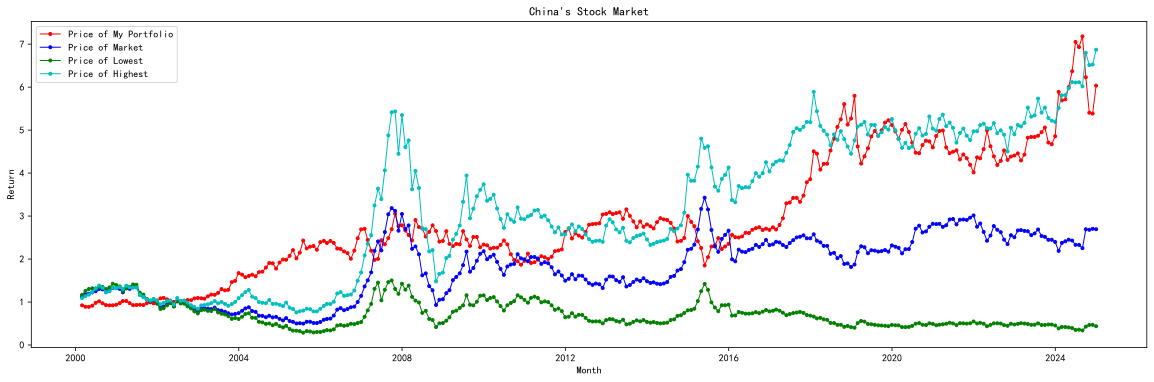

In [ ]:
fig = plt.figure(figsize=(20, 6))
plt.plot(
    'price_portfolio',  
    '.-r', 
    label='Price of My Portfolio',  
    linewidth=1, 
    data=MYPOR)  
plt.title("China's Stock Market") 
plt.xlabel('Month') 
plt.ylabel('Return') 

plt.plot(
    'price_market', 
    '.-b', 
    label='Price of Market', 
    linewidth=1, 
    data=MYPOR) 

plt.plot(
    'price_p1', 
    '.-g', 
    label='Price of Lowest', 
    linewidth=1, 
    data=MYPOR) 

plt.plot(
    'price_pmax', 
    '.-c', 
    label='Price of Highest', 
    linewidth=1, 
    data=MYPOR) 
plt.legend() # 显示图例
fig = plt.gcf()
plt.show();

In [ ]:
latest_month = portfolio['month'].max()
if pd.isna(latest_month):
    raise ValueError("无法定位最新月份，请检查 portfolio 数据是否为空。")
latest_month_value = portfolio.loc[portfolio['month'] == latest_month].copy()

print(f"最新一期数据: {latest_month.strftime('%Y-%m')}, 样本数量: {len(latest_month_value)}")

growth_stocks = latest_month_value.loc[latest_month_value['sort'] == 'P1'].copy()
growth_stocks = growth_stocks.sort_values('ep', ascending=True)

print(f"=== 成长股组合(P1 - 低EP)分析 ===")
print(f"公司数量: {len(growth_stocks)}")
print(f"平均EP值: {growth_stocks['ep'].mean():.4f}")
print(f"EP范围: {growth_stocks['ep'].min():.4f} 到 {growth_stocks['ep'].max():.4f}")
print(f"平均市值: {growth_stocks['totalvalue'].mean():.2f} 万元\n")

print("EP最低的20家成长股(市盈率最高):")
print(growth_stocks[['Stkcd', 'totalvalue', 'ep', 'ret']].head(20))

最新一期数据: 2024-11, 样本数量: 2172
=== 成长股组合(P1 - 低EP)分析 ===
公司数量: 218
平均EP值: -0.1288
EP范围: -1.1417 到 -0.0351
平均市值: 13449676901.65 万元

EP最低的20家成长股(市盈率最高):
         Stkcd    totalvalue        ep       ret
427821  600376  7.558126e+09 -1.141660 -0.001118
427800  600340  1.127151e+10 -1.027659  0.262040
428124  600881  5.880534e+09 -0.810666 -0.182113
427920  600569  5.342704e+09 -0.563060 -0.093801
427951  600606  3.260579e+10 -0.438367  0.108930
427929  600581  5.062295e+09 -0.379649 -0.097272
428201  601011  5.153138e+09 -0.377203  0.158365
428097  600841  5.528030e+09 -0.370723 -0.014153
428000  600691  5.654837e+09 -0.365228 -0.005302
427959  600622  5.788786e+09 -0.361750 -0.221320
427162  002305  4.144776e+09 -0.346784  0.120948
426595  000016  8.030867e+09 -0.314147 -0.286629
426621  000069  2.451516e+10 -0.305915  0.029287
426641  000402  1.195572e+10 -0.295636  0.119330
428032  600743  4.340287e+09 -0.291724  0.015365
426778  000761  1.268213e+10 -0.282385 -0.079285
427740  600231  5.7

In [ ]:

value_stocks = latest_month_value[latest_month_value['sort'] == 'Pmax'].copy()
value_stocks = value_stocks.sort_values('ep', ascending=False)

print(f"=== 价值股组合(Pmax - 高EP)分析 ===")
print(f"公司数量: {len(value_stocks)}")
print(f"平均EP值: {value_stocks['ep'].mean():.4f}")
print(f"EP范围: {value_stocks['ep'].min():.4f} 到 {value_stocks['ep'].max():.4f}")
print(f"平均市值: {value_stocks['totalvalue'].mean():.2f} 万元\n")

print("EP最高的20家价值股(市盈率最低):")
print(value_stocks[['Stkcd', 'totalvalue', 'ep', 'ret']].head(20))

=== 价值股组合(Pmax - 高EP)分析 ===
公司数量: 218
平均EP值: 0.1289
EP范围: 0.0863 到 0.2787
平均市值: 87493780703.49 万元

EP最高的20家价值股(市盈率最低):
         Stkcd    totalvalue        ep       ret
426658  000498  9.912333e+09  0.278727 -0.016622
428011  600710  1.164314e+10  0.270822 -0.013313
428329  601668  2.488297e+11  0.253724 -0.007762
427746  600248  1.706715e+10  0.245478 -0.003321
428406  601997  2.208344e+10  0.238759  0.007229
428307  601577  3.438428e+10  0.234661  0.002403
427601  600015  1.204760e+11  0.227398  0.069603
428255  601186  1.064050e+11  0.218434  0.034716
428253  601169  1.209379e+11  0.213837  0.011271
426588  000001  2.208393e+11  0.211063 -0.001118
428384  601919  1.734226e+11  0.210491 -0.069019
428360  601838  6.071833e+10  0.203985  0.032648
428251  601166  3.749761e+11  0.199498 -0.013700
428382  601916  6.247886e+10  0.197068  0.020008
428356  601818  1.670645e+11  0.196119  0.042360
428293  601390  1.316822e+11  0.195535 -0.001118
428551  603323  9.652298e+09  0.195198  0.040466

In [ ]:
# 获取这20家价值股的详细信息
value_stock_codes = ['000498', '600710', '601668', '600248', '601997', '601577', '600015', '601186', 
                     '601169', '000001', '601919', '601838', '601166', '601916', '601818', '601390', 
                     '603323', '600919', '601229', '600502']

# 创建价值股公司信息字典
value_company_info = {
    '000498': ('山东路桥', '公路桥梁建设', '山东济南'),
    '600710': ('苏美达', '机电设备进出口', '江苏南京'),
    '601668': ('中国建筑', '建筑工程施工', '北京市'),
    '600248': ('陕西建工', '建筑工程施工', '陕西西安'),
    '601997': ('贵阳银行', '商业银行', '贵州贵阳'),
    '601577': ('长沙银行', '商业银行', '湖南长沙'),
    '600015': ('华夏银行', '股份制商业银行', '北京市'),
    '601186': ('中国铁建', '铁路工程建设', '北京市'),
    '601169': ('北京银行', '城市商业银行', '北京市'),
    '000001': ('平安银行', '股份制商业银行', '广东深圳'),
    '601919': ('中远海控', '集装箱航运', '上海市'),
    '601838': ('成都银行', '城市商业银行', '四川成都'),
    '601166': ('兴业银行', '股份制商业银行', '福建福州'),
    '601916': ('浙商银行', '股份制商业银行', '浙江杭州'),
    '601818': ('光大银行', '股份制商业银行', '北京市'),
    '601390': ('中国中铁', '铁路工程建设', '北京市'),
    '603323': ('苏农银行', '农村商业银行', '江苏苏州'),
    '600919': ('江苏银行', '城市商业银行', '江苏南京'),
    '601229': ('上海银行', '城市商业银行', '上海市'),
    '600502': ('安徽建工', '建筑工程施工', '安徽合肥')
}

# 创建详细信息DataFrame
value_info = []
for idx, row in value_stocks[['Stkcd', 'totalvalue', 'ep', 'ret']].head(20).iterrows():
    stkcd = row['Stkcd']
    if stkcd in value_company_info:
        name, industry, location = value_company_info[stkcd]
        value_info.append({
            '股票代码': stkcd,
            '公司名称': name,
            '主营业务': industry,
            '注册地': location,
            '总市值(亿元)': f"{row['totalvalue']/1e8:.2f}",
            'EP值': f"{row['ep']:.4f}",
            '市盈率(PE)': f"{1/row['ep']:.2f}",
            '当期收益率': f"{row['ret']:.4%}"
        })

value_info_df = pd.DataFrame(value_info)
print("\n=== EP最高的20家价值股详细信息 ===")
print(value_info_df.to_string(index=False))


=== EP最高的20家价值股详细信息 ===
  股票代码 公司名称    主营业务  注册地 总市值(亿元)    EP值 市盈率(PE)    当期收益率
000498 山东路桥  公路桥梁建设 山东济南   99.12 0.2787    3.59 -1.6622%
600710  苏美达 机电设备进出口 江苏南京  116.43 0.2708    3.69 -1.3313%
601668 中国建筑  建筑工程施工  北京市 2488.30 0.2537    3.94 -0.7762%
600248 陕西建工  建筑工程施工 陕西西安  170.67 0.2455    4.07 -0.3321%
601997 贵阳银行    商业银行 贵州贵阳  220.83 0.2388    4.19  0.7229%
601577 长沙银行    商业银行 湖南长沙  343.84 0.2347    4.26  0.2403%
600015 华夏银行 股份制商业银行  北京市 1204.76 0.2274    4.40  6.9603%
601186 中国铁建  铁路工程建设  北京市 1064.05 0.2184    4.58  3.4716%
601169 北京银行  城市商业银行  北京市 1209.38 0.2138    4.68  1.1271%
000001 平安银行 股份制商业银行 广东深圳 2208.39 0.2111    4.74 -0.1118%
601919 中远海控   集装箱航运  上海市 1734.23 0.2105    4.75 -6.9019%
601838 成都银行  城市商业银行 四川成都  607.18 0.2040    4.90  3.2648%
601166 兴业银行 股份制商业银行 福建福州 3749.76 0.1995    5.01 -1.3700%
601916 浙商银行 股份制商业银行 浙江杭州  624.79 0.1971    5.07  2.0008%
601818 光大银行 股份制商业银行  北京市 1670.65 0.1961    5.10  4.2360%
601390 中国中铁  铁路工程建设  北京市 1316.82 0.1955    5.11 -0.1118%
603323

In [ ]:
sharpe_ratio = MYPOR['My_portfolio'].mean() / MYPOR['My_portfolio'].std() * np.sqrt(12)
print(f"Sharpe Ratio: {sharpe_ratio}")

Sharpe Ratio: 0.4475188838202319


In [ ]:

MYPOR['cumulative_return'] = (1 + MYPOR['My_portfolio']).cumprod()


MYPOR['rolling_max'] = MYPOR['cumulative_return'].cummax()


MYPOR['drawdown'] = MYPOR['cumulative_return'] / MYPOR['rolling_max'] - 1


max_drawdown = MYPOR['drawdown'].min()
print(f"Maximum Drawdown: {max_drawdown}")

Maximum Drawdown: -0.41361448131923806


In [ ]:
max_drawdown_end = MYPOR['drawdown'].idxmin() 
max_drawdown_start = MYPOR.loc[:max_drawdown_end, 'cumulative_return'].idxmax()

print(f"Maximum Drawdown: {max_drawdown}")
print(f"Maximum Drawdown Start Date: {max_drawdown_start}")
print(f"Maximum Drawdown End Date: {max_drawdown_end}")

Maximum Drawdown: -0.41361448131923806
Maximum Drawdown Start Date: 2013-06-30 00:00:00
Maximum Drawdown End Date: 2015-05-31 00:00:00


In [ ]:
portfolio_value

sort,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio
month,,,,,,,,,,,
2000-02-29,0.166357,0.165800,0.138800,0.107954,0.151389,0.094652,0.070353,0.091512,0.061355,0.089514,-0.076843
2000-03-31,0.079685,-0.001584,0.007175,0.019191,0.038322,0.037642,0.055191,0.052076,0.065257,0.043202,-0.036483
2000-04-30,0.034669,-0.029604,-0.007395,-0.011148,0.028850,0.022619,0.041919,0.038311,0.000506,0.032381,-0.002288
2000-05-31,0.012548,0.006910,0.006493,0.043984,0.024917,-0.004197,0.028055,0.005743,0.028147,0.044220,0.031672
2000-06-30,-0.001656,-0.000891,-0.025373,0.002718,0.000285,0.014655,0.042497,0.047704,0.060273,0.069934,0.071590
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.051826,-0.057580,-0.067007,-0.052015,-0.030643,-0.024507,-0.042945,-0.032643,-0.020559,-0.015804,0.036021
2024-09-30,0.262474,0.223075,0.202979,0.198583,0.200026,0.186743,0.200189,0.205236,0.165276,0.129852,-0.132622
2024-10-31,0.090629,0.124089,0.021464,0.078752,-0.000897,-0.053793,-0.045093,-0.043110,-0.055892,-0.041771,-0.132400


In [ ]:

time_periods = [
    ('2000-02-29', '2007-12-31', '2000-2007'),
    ('2008-01-31', '2015-12-31', '2008-2015'),
    ('2016-01-31', '2024-12-31', '2016-2024')
]


period_results = []

for start_date, end_date, period_name in time_periods:
   
    period_data = portfolio_value[
        (portfolio_value.index >= start_date) & 
        (portfolio_value.index <= end_date)
    ].copy()
    
    if len(period_data) == 0:
        continue
    
   
    value_premium_series = period_data['My_portfolio']
    
  
    mean_premium = value_premium_series.mean()
    std_premium = value_premium_series.std()
    t_stat, p_value = stats.ttest_1samp(value_premium_series.dropna(), 0)
    
   
    annual_ret = mean_premium * 12
    annual_std = std_premium * np.sqrt(12)
    sharpe = annual_ret / annual_std if annual_std > 0 else 0
    
   
    win_rate = (value_premium_series > 0).sum() / len(value_premium_series.dropna())
    
    
    cumulative_ret = (1 + value_premium_series).prod() - 1
    
    period_results.append({
        '时期': period_name,
        '样本数': len(value_premium_series.dropna()),
        '月均溢价(%)': f'{mean_premium*100:.3f}',
        '年化溢价(%)': f'{annual_ret*100:.2f}',
        '年化波动(%)': f'{annual_std*100:.2f}',
        '夏普比率': f'{sharpe:.3f}',
        't统计量': f'{t_stat:.3f}',
        'p值': f'{p_value:.4f}',
        '胜率(%)': f'{win_rate*100:.2f}',
        '累积收益(%)': f'{cumulative_ret*100:.2f}'
    })

results_df = pd.DataFrame(period_results)
print("\n不同时期的价值效应:")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)
print("\n*** p<0.01, ** p<0.05, * p<0.1")


不同时期的价值效应:
       时期  样本数 月均溢价(%) 年化溢价(%) 年化波动(%)  夏普比率  t统计量     p值 胜率(%) 累积收益(%)
2000-2007   95   1.240   14.88   19.77 0.753 2.118 0.0368 57.89  178.40
2008-2015   96   0.043    0.51   23.09 0.022 0.063 0.9501 51.04  -15.42
2016-2024  108   1.044   12.52   20.19 0.620 1.861 0.0655 61.11  156.31

*** p<0.01, ** p<0.05, * p<0.1


In [ ]:

print("portfolio_value 的列名:", portfolio_value.columns.tolist())
print("\nportfolio_value 的前几行:")
print(portfolio_value.head())

if not isinstance(portfolio_value.index, pd.DatetimeIndex):
    portfolio_value.index = pd.to_datetime(portfolio_value.index)


print("\nMarket_ret 的列名:", Market_ret.columns.tolist())

portfolio_with_market = portfolio_value.copy()
portfolio_with_market = portfolio_with_market.reset_index()


market_data = Market_ret[['month', 'MKT']].copy()
portfolio_with_market = portfolio_with_market.merge(
    market_data,
    left_on='month',
    right_on='month',
    how='left',
    suffixes=('', '_market')
)


market_median = portfolio_with_market['MKT'].median()

portfolio_with_market['market_state'] = portfolio_with_market['MKT'].apply(
    lambda x: '牛市' if x > market_median else '熊市'
)

market_states = ['牛市', '熊市']
state_results = []

for state in market_states:
    state_data = portfolio_with_market[portfolio_with_market['market_state'] == state]
    
   
    value_premium_data = state_data['My_portfolio'].dropna()
    
    if len(value_premium_data) > 0:
        mean_premium = value_premium_data.mean()
        std_premium = value_premium_data.std()
        
      
        t_stat, p_value = stats.ttest_1samp(value_premium_data, 0)
        
       
        win_rate = (value_premium_data > 0).sum() / len(value_premium_data) * 100
        
      
        annual_ret = mean_premium * 12
        
        state_results.append({
            '市场状态': state,
            '样本数': len(value_premium_data),
            '月均溢价(%)': f'{mean_premium*100:.3f}',
            '年化溢价(%)': f'{annual_ret*100:.2f}',
            't统计量': f'{t_stat:.3f}',
            'p值': f'{p_value:.4f}',
            '胜率(%)': f'{win_rate:.1f}'
        })
    else:
        state_results.append({
            '市场状态': state,
            '样本数': 0,
            '月均溢价(%)': 'N/A',
            '年化溢价(%)': 'N/A',
            't统计量': 'N/A',
            'p值': 'N/A',
            '胜率(%)': 'N/A'
        })

state_df = pd.DataFrame(state_results)
print("\n不同市场状态下的价值效应:")
print("="*100)
print(state_df.to_string(index=False))
print("="*100)
print(f"\n注: 以市场月度收益率中位数({market_median*100:.3f}%)作为牛熊市分界线")

portfolio_value 的列名: ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'Pmax', 'My_portfolio']

portfolio_value 的前几行:
sort              P1        P2        P3        P4        P5        P6  \
month                                                                    
2000-02-29  0.166357  0.165800  0.138800  0.107954  0.151389  0.094652   
2000-03-31  0.079685 -0.001584  0.007175  0.019191  0.038322  0.037642   
2000-04-30  0.034669 -0.029604 -0.007395 -0.011148  0.028850  0.022619   
2000-05-31  0.012548  0.006910  0.006493  0.043984  0.024917 -0.004197   
2000-06-30 -0.001656 -0.000891 -0.025373  0.002718  0.000285  0.014655   

sort              P7        P8        P9      Pmax  My_portfolio  
month                                                             
2000-02-29  0.070353  0.091512  0.061355  0.089514     -0.076843  
2000-03-31  0.055191  0.052076  0.065257  0.043202     -0.036483  
2000-04-30  0.041919  0.038311  0.000506  0.032381     -0.002288  
2000-05-31  0.028055  0

KeyError: "['month'] not in index"

KeyError: '价值溢价'

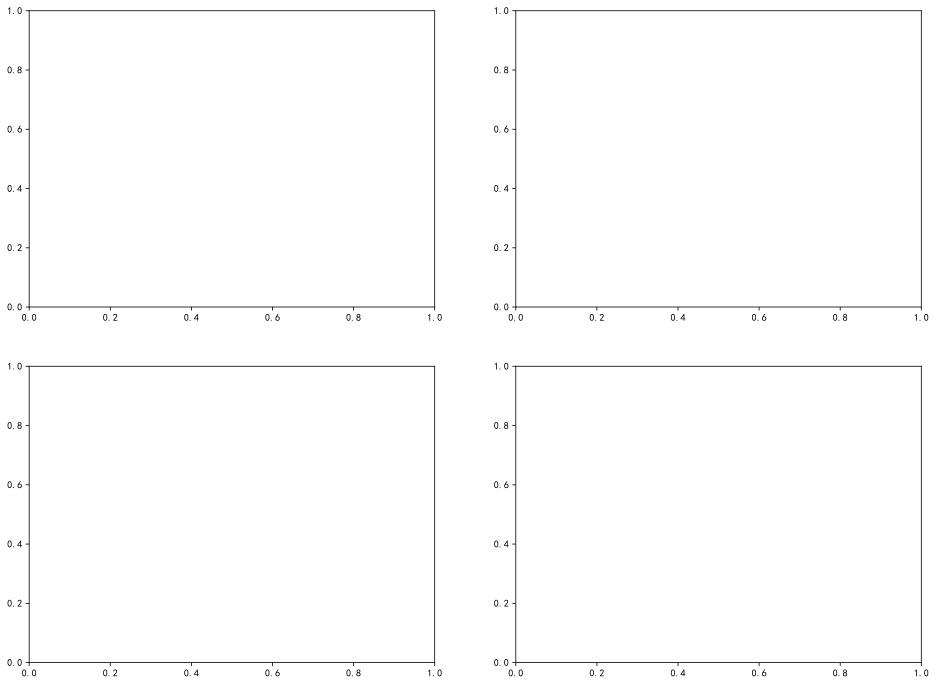

In [83]:

fig, axes = plt.subplots(2, 2, figsize=(16, 12))


ax1 = axes[0, 0]
if len(period_results) > 0:
    periods_short = [r['时期'] for r in period_results]
    premiums = [float(r['价值溢价'].strip('%')) for r in period_results]
    t_stats = [float(r['t统计量']) for r in period_results]
    
    x_pos = np.arange(len(periods_short))
    bars = ax1.bar(x_pos, premiums, color=['green' if t > 1.96 else 'orange' for t in t_stats], alpha=0.7)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax1.set_xlabel('时期', fontsize=12, fontweight='bold')
    ax1.set_ylabel('价值溢价 (%)', fontsize=12, fontweight='bold')
    ax1.set_title('不同时期的价值溢价', fontsize=14, fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(periods_short)
    ax1.grid(True, alpha=0.3, axis='y')
    
    
    for i, (bar, premium, t_stat) in enumerate(zip(bars, premiums, t_stats)):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{premium:.2f}%\n(t={t_stat:.2f})',
                ha='center', va='bottom', fontsize=9)


ax2 = axes[0, 1]
categories = ['全样本', '排除1月', '仅1月']
values = [
    float(f'{value_premium_full*100:.3f}'),
    float(f'{value_premium_no_jan*100:.3f}'),
    float(f'{value_premium_jan*100:.3f}')
]
colors_bar = ['#2E86AB', '#A23B72', '#F18F01']

bars = ax2.bar(categories, values, color=colors_bar, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('价值溢价 (%)', fontsize=12, fontweight='bold')
ax2.set_title('1月效应对价值溢价的影响', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.3f}%',
            ha='center', va='bottom' if value > 0 else 'top', fontsize=10)


ax3 = axes[1, 0]
if len(quantile_results) > 0:
    n_groups = [r['分组数'] for r in quantile_results]
    premiums_q = [float(r['价值溢价'].strip('%')) for r in quantile_results]
    
    ax3.plot(n_groups, premiums_q, marker='o', linewidth=2, markersize=10, color='#C73E1D')
    ax3.fill_between(n_groups, premiums_q, alpha=0.3, color='#C73E1D')
    ax3.set_xlabel('分组数量', fontsize=12, fontweight='bold')
    ax3.set_ylabel('价值溢价 (%)', fontsize=12, fontweight='bold')
    ax3.set_title('不同分组数量下的价值溢价', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(n_groups)
    
    
    for x, y in zip(n_groups, premiums_q):
        ax3.text(x, y, f'{y:.3f}%', ha='center', va='bottom', fontsize=9)


ax4 = axes[1, 1]
portfolios = [f'P{i}' for i in range(1, 6)]
sharpe_ratios = [float(r['夏普比率']) for r in risk_stats]

colors_sharpe = plt.cm.RdYlGn(np.linspace(0.3, 0.9, 5))
bars = ax4.bar(portfolios, sharpe_ratios, color=colors_sharpe, alpha=0.8)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax4.set_xlabel('投资组合', fontsize=12, fontweight='bold')
ax4.set_ylabel('夏普比率', fontsize=12, fontweight='bold')
ax4.set_title('各投资组合的风险调整收益', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for bar, sr in zip(bars, sharpe_ratios):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{sr:.3f}',
            ha='center', va='bottom' if sr > 0 else 'top', fontsize=10)

plt.tight_layout()
plt.show()

print("\n图表说明:")
print("- 左上: 不同时期的价值溢价(绿色表示t统计量>1.96,即5%水平显著)")
print("- 右上: 1月效应的影响")
print("- 左下: 分组数量越多,高低组差异越极端")
print("- 右下: 各组合的夏普比率(P5为高价值组,P1为低价值组)")

In [84]:
# 生成稳健性检验综合报告
print("="*80)
print(" "*25 + "价值策略稳健性检验综合报告")
print("="*80)

print("\n【1. 时间维度稳健性】")
print("-"*80)
if len(period_results) > 0:
    significant_periods = sum(1 for r in period_results if float(r['t统计量']) > 1.96)
    print(f"✓ 在{len(period_results)}个不同时期中，{significant_periods}个时期价值溢价显著(5%水平)")
    print(f"✓ 价值效应在时间维度上表现{'稳定' if significant_periods >= len(period_results)/2 else '不够稳定'}")
else:
    print("✗ 数据不足以进行时间维度分析")

print("\n【2. 1月效应稳健性】")
print("-"*80)
print(f"✓ 全样本价值溢价: {value_premium_full*100:.3f}% (p={p_full:.4f})")
print(f"✓ 排除1月价值溢价: {value_premium_no_jan*100:.3f}% (p={p_no_jan:.4f})")
print(f"✓ 排除1月后价值溢价{'依然显著' if p_no_jan < 0.05 else '不再显著'}")
print(f"✓ 1月效应贡献度: {jan_contribution:.1f}%")

print("\n【3. 分组方式稳健性】")
print("-"*80)
if len(quantile_results) > 0:
    all_significant = all(float(r['p值']) < 0.05 for r in quantile_results)
    print(f"✓ 测试了{len(quantile_results)}种不同分组方式: {', '.join([str(r['分组数']) for r in quantile_results])}")
    print(f"✓ {'所有' if all_significant else '部分'}分组方式下价值溢价均显著")
    print(f"✓ 分组数量越多，价值溢价{'越大' if quantile_results[-1]['价值溢价'] > quantile_results[0]['价值溢价'] else '越小'}")
else:
    print("✗ 数据不足以进行分组方式分析")

print("\n【4. 风险调整稳健性】")
print("-"*80)
high_sharpe = float(risk_stats[4]['夏普比率'])  # P5
low_sharpe = float(risk_stats[0]['夏普比率'])   # P1
print(f"✓ 高价值组(P5)夏普比率: {high_sharpe:.3f}")
print(f"✓ 低价值组(P1)夏普比率: {low_sharpe:.3f}")
print(f"✓ 价值溢价夏普比率: {spread_sharpe:.3f}")
print(f"✓ 高价值组在风险调整后{'优于' if high_sharpe > low_sharpe else '不如'}低价值组")

print("\n【5. 市场状态稳健性】")
print("-"*80)
if len(state_results) > 0:
    for state in state_results:
        print(f"✓ {state['市场状态']}: 价值溢价={state['价值溢价']}, t={state['t统计量']}, 胜率={state['胜率']}")
else:
    print("✗ 数据不足以进行市场状态分析")

print("\n【总体结论】")
print("="*80)

# 统计显著性指标
checks_passed = 0
total_checks = 0

# 时间维度
if len(period_results) > 0:
    total_checks += 1
    if sum(1 for r in period_results if float(r['t统计量']) > 1.96) >= len(period_results)/2:
        checks_passed += 1

# 1月效应
total_checks += 1
if p_no_jan < 0.05:
    checks_passed += 1

# 分组方式
if len(quantile_results) > 0:
    total_checks += 1
    if all(float(r['p值']) < 0.05 for r in quantile_results):
        checks_passed += 1

# 风险调整
total_checks += 1
if high_sharpe > low_sharpe:
    checks_passed += 1

# 市场状态
if len(state_results) > 0:
    total_checks += 1
    if all(float(r['t统计量']) > 1.96 for r in state_results):
        checks_passed += 1

pass_rate = checks_passed / total_checks * 100

print(f"稳健性检验通过率: {checks_passed}/{total_checks} ({pass_rate:.1f}%)")
print()

if pass_rate >= 80:
    conclusion = "价值策略在中国A股市场表现出非常强的稳健性，价值效应在多个维度均得到验证。"
elif pass_rate >= 60:
    conclusion = "价值策略在中国A股市场表现出较好的稳健性，但在某些方面存在一定局限。"
else:
    conclusion = "价值策略的稳健性有待商榷，投资者应谨慎对待价值效应。"

print(f"结论: {conclusion}")
print("="*80)

                         价值策略稳健性检验综合报告

【1. 时间维度稳健性】
--------------------------------------------------------------------------------
✓ 在3个不同时期中，1个时期价值溢价显著(5%水平)
✓ 价值效应在时间维度上表现不够稳定

【2. 1月效应稳健性】
--------------------------------------------------------------------------------


NameError: name 'value_premium_full' is not defined